In [1]:
import os
import tensorflow.keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tensorflow.keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tensorflow.keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = tensorflow.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = tensorflow.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tensorflow.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [15]:
import tensorflow.compat.v1 as tf
import tensorflow.keras.backend as K

"""
# 撰寫自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)
"""
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [17]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
"""
# 在 compile 時，使用自定義的 loss function
"""
model.compile(loss=focal_loss(), metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

#valid_f1sc = model.history.history['val_f1sc']

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512 

50000/50000 [==============================] - 1s 19us/sample - loss: 0.1432 - accuracy: 0.9833 - val_loss: 6.0342 - val_accuracy: 0.4834
Epoch 46/50
50000/50000 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.98 - 1s 20us/sample - loss: 0.1270 - accuracy: 0.9860 - val_loss: 6.2143 - val_accuracy: 0.4746
Epoch 47/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1163 - accuracy: 0.9877 - val_loss: 6.3321 - val_accuracy: 0.4755
Epoch 48/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1060 - accuracy: 0.9901 - val_loss: 6.3617 - val_accuracy: 0.4822
Epoch 49/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.0963 - accuracy: 0.9915 - val_loss: 6.3023 - val_accuracy: 0.4803
Epoch 50/50
50000/50000 [==============================] - 1s 19us/sample - loss: 0.0877 - accuracy: 0.9928 - val_loss: 6.3330 - val_accuracy: 0.4847


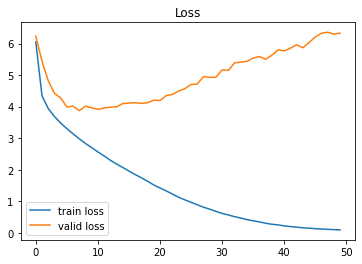

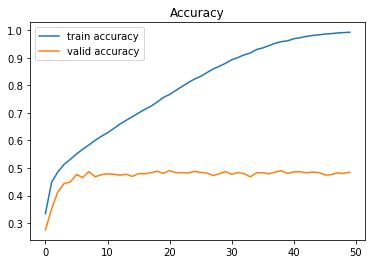

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work

請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

In [19]:
def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fcl_weights=0.3):
    gamma = float(gamma)
    alpha = float(alpha)
    def CE_focal_loss(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        ce_loss = tensorflow.keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weights*ce_loss) + (fcl_weights*tf.reduce_mean(reduced_fl) )
    return CE_focal_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [20]:
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_weights=ce_w, fcl_weights=1.-ce_w), 
                  metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_15 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_17 (

50000/50000 [==============================] - 1s 20us/sample - loss: 0.1309 - accuracy: 0.9853 - val_loss: 6.1630 - val_accuracy: 0.4756
Epoch 46/50
50000/50000 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.98 - 1s 21us/sample - loss: 0.1176 - accuracy: 0.9887 - val_loss: 6.1501 - val_accuracy: 0.4769
Epoch 47/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1054 - accuracy: 0.9905 - val_loss: 6.1742 - val_accuracy: 0.4878
Epoch 48/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.0977 - accuracy: 0.9913 - val_loss: 6.3867 - val_accuracy: 0.4749
Epoch 49/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.0898 - accuracy: 0.9926 - val_loss: 6.2562 - val_accuracy: 0.4870
Epoch 50/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.0813 - accuracy: 0.9935 - val_loss: 6.3554 - val_accuracy: 0.4767
Numbers of exp: 1, ce_weight: 0.30
Model: "model_6"
__________________

Epoch 39/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.3699 - accuracy: 0.9378 - val_loss: 4.5078 - val_accuracy: 0.4678
Epoch 40/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.3375 - accuracy: 0.9455 - val_loss: 4.5985 - val_accuracy: 0.4736
Epoch 41/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.3114 - accuracy: 0.9517 - val_loss: 4.5489 - val_accuracy: 0.4850
Epoch 42/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.2844 - accuracy: 0.9574 - val_loss: 4.7761 - val_accuracy: 0.4668
Epoch 43/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.2623 - accuracy: 0.9624 - val_loss: 4.7582 - val_accuracy: 0.4752
Epoch 44/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.2405 - accuracy: 0.9673 - val_loss: 4.7107 - val_accuracy: 0.4829
Epoch 45/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.2199 - accuracy:

50000/50000 [==============================] - 1s 20us/sample - loss: 0.6456 - accuracy: 0.8685 - val_loss: 3.2938 - val_accuracy: 0.4782
Epoch 34/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.6052 - accuracy: 0.8793 - val_loss: 3.4017 - val_accuracy: 0.4668
Epoch 35/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.5724 - accuracy: 0.8860 - val_loss: 3.4191 - val_accuracy: 0.4771
Epoch 36/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.5273 - accuracy: 0.8996 - val_loss: 3.4532 - val_accuracy: 0.4764
Epoch 37/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.4974 - accuracy: 0.9057 - val_loss: 3.5059 - val_accuracy: 0.4755
Epoch 38/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.4664 - accuracy: 0.9127 - val_loss: 3.5887 - val_accuracy: 0.4767
Epoch 39/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.4346 - accuracy: 0.9231 - va

Epoch 28/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.9251 - accuracy: 0.7820 - val_loss: 2.3568 - val_accuracy: 0.4938
Epoch 29/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.8892 - accuracy: 0.7906 - val_loss: 2.3935 - val_accuracy: 0.4916
Epoch 30/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.8494 - accuracy: 0.8011 - val_loss: 2.4280 - val_accuracy: 0.4851
Epoch 31/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.8135 - accuracy: 0.8134 - val_loss: 2.4694 - val_accuracy: 0.4897
Epoch 32/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.7775 - accuracy: 0.8214 - val_loss: 2.4747 - val_accuracy: 0.4892
Epoch 33/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.7363 - accuracy: 0.8323 - val_loss: 2.5340 - val_accuracy: 0.4844
Epoch 34/50
50000/50000 [==============================] - 1s 21us/sample - loss: 0.7028 - accuracy:

50000/50000 [==============================] - 1s 20us/sample - loss: 1.0297 - accuracy: 0.6500 - val_loss: 1.4519 - val_accuracy: 0.4954
Epoch 23/50
50000/50000 [==============================] - 1s 20us/sample - loss: 1.0068 - accuracy: 0.6586 - val_loss: 1.4566 - val_accuracy: 0.4945
Epoch 24/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.9865 - accuracy: 0.6665 - val_loss: 1.4623 - val_accuracy: 0.4948
Epoch 25/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.9656 - accuracy: 0.6745 - val_loss: 1.4692 - val_accuracy: 0.4974
Epoch 26/50
50000/50000 [==============================] - 1s 20us/sample - loss: 0.9432 - accuracy: 0.6845 - val_loss: 1.4653 - val_accuracy: 0.4960
Epoch 27/50
50000/50000 [==============================] - ETA: 0s - loss: 0.9230 - accuracy: 0.69 - 1s 20us/sample - loss: 0.9247 - accuracy: 0.6944 - val_loss: 1.4678 - val_accuracy: 0.4939
Epoch 28/50
50000/50000 [==============================] - 1s 20us/sam

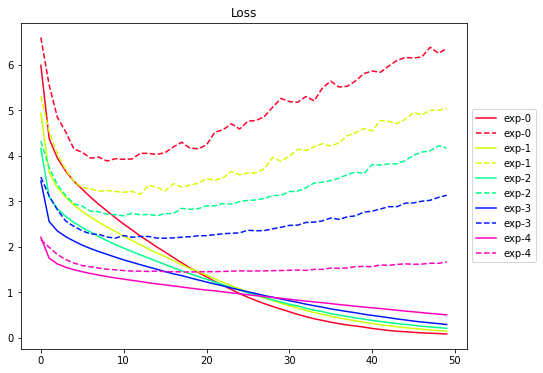

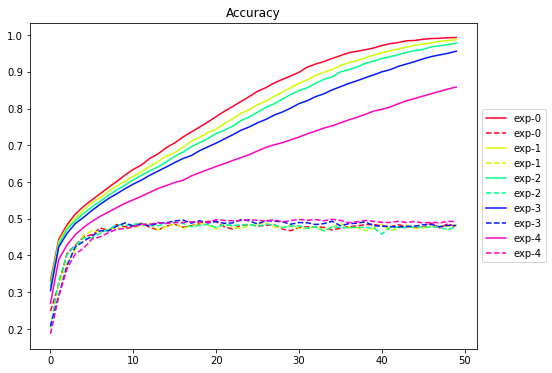

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()